In [1]:
# %pip install -r requirements.txt

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("CO2Analysis").getOrCreate()

co2_df = spark.read.csv(
    "hdfs://26.3.217.119:9000/climate_data/trend_analytics/co2_mm_mlo.csv",
    header=True,
    schema="year INT, month INT, decimal_date DOUBLE, average DOUBLE, deseasonalized DOUBLE, ndays INT, sdev DOUBLE, unc DOUBLE",
)

ch4_df = spark.read.csv(
    "hdfs://26.3.217.119:9000/climate_data/trend_analytics/ch4_mm_gl.csv",
    header=True,
    schema="year INT, month INT, decimal DOUBLE, average DOUBLE, average_unc DOUBLE, trend DOUBLE, trend_unc DOUBLE",
)

n2o_df = spark.read.csv(
    "hdfs://26.3.217.119:9000/climate_data/trend_analytics/n2o_mm_gl.csv",
    header=True,
    schema="year INT, month INT, decimal DOUBLE, average DOUBLE, average_unc DOUBLE, trend DOUBLE, trend_unc DOUBLE",
)

sf6_df = spark.read.csv(
    "hdfs://26.3.217.119:9000/climate_data/trend_analytics/sf6_mm_gl.csv",
    header=True,
    schema="year INT, month INT, decimal DOUBLE, average DOUBLE, average_unc DOUBLE, trend DOUBLE, trend_unc DOUBLE",
)

In [3]:
co2_df

DataFrame[year: int, month: int, decimal_date: double, average: double, deseasonalized: double, ndays: int, sdev: double, unc: double]

In [10]:
ch4_df

DataFrame[year: int, month: int, decimal: double, average: double, average_unc: double, trend: double, trend_unc: double]

In [ ]:
n2o_df

In [ ]:
sf6_df

In [4]:
clean_co2 = co2_df.filter((col("average") > 0) & (col("year") >= 1958) & (col("month").between(1, 12)))

In [5]:
clean_co2

DataFrame[year: int, month: int, decimal_date: double, average: double, deseasonalized: double, ndays: int, sdev: double, unc: double]

In [7]:
co2_clean = clean_co2.select("year", "month", "decimal_date", "average", "deseasonalized")

In [8]:
annual_co2 = co2_clean.groupBy("year").agg(avg("average").alias("avg_co2_ppm")).orderBy("year")

In [9]:
annual_co2

DataFrame[year: int, avg_co2_ppm: double]

In [34]:
assembler = VectorAssembler(inputCols=["year"], outputCol="features")

data = assembler.transform(annual_co2.select("year", "avg_co2_ppm"))

lr = LinearRegression(featuresCol="features", labelCol="avg_co2_ppm", predictionCol="prediction")

model = lr.fit(data)

In [35]:
print(f"Slope: {model.coefficients[0]:.3f} ppm/year")
print(f"Intercept: {model.intercept:.1f} ppm")
print(f"R-squared: {model.summary.r2:.3f}")


Slope: 1.657 ppm/year
Intercept: -2940.3 ppm
R-squared: 0.980


In [36]:
annual_pd = annual_co2.toPandas()

In [37]:
annual_pd

,year,avg_co2_ppm
0,1958,315.237000
1,1959,315.981667
2,1960,316.908333
3,1961,317.643333
4,1962,318.453333
...,...,...
63,2021,416.414167
64,2022,418.528333
65,2023,421.075833
66,2024,424.604167


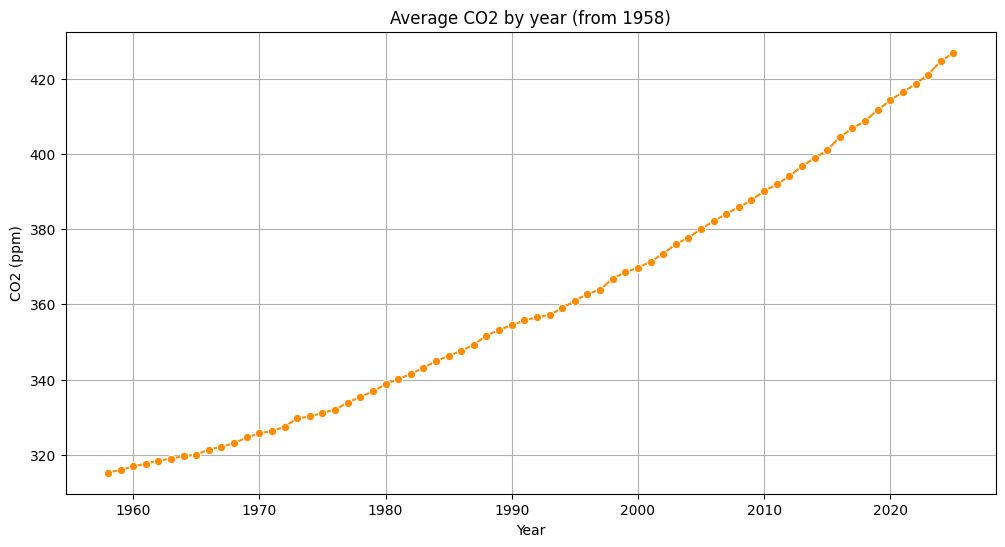

In [38]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="year", y="avg_co2_ppm", data=annual_pd, marker="o", color="darkorange")

plt.title("Average CO2 by year (from 1958)")
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
plt.grid(True)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_timestamp, expr, split, when, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
from sedona.spark import SedonaContext
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.SpatialRDD import PointRDD
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.enums import FileDataSplitter
from sedona.core.geom.envelope import Envelope
from sedona.sql.types import GeometryType
import yaml
import os
from shapely import wkt
from shapely.geometry import box

from pyspark.sql.functions import to_json, struct

In [2]:
HDFS_PREFIX = "hdfs://26.3.217.119:9000"
READ_DIR = "building.json"
SAVE_DIR = f"{HDFS_PREFIX}/climate_data/uhi_index_analytics/preprocessed/"

In [3]:
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)
COORDS = config["coords"]
CRS = config["satellite_config"]["params"]["crs"]

In [4]:
# def create_spark_session():
#     spark = (
#         SparkSession.builder.appName("GeoSpatialPreprocessing")
#         .config("spark.serializer", KryoSerializer.getName)
#         .config("spark.kryo.registrator", SedonaKryoRegistrator.getName)
#         .config(
#             "spark.jars.packages",
#             "org.apache.sedona:sedona-python-adapter-3.0_2.12:1.1.1-incubating,"
#             "org.datasyslab:geotools-wrapper:1.1.0-25.2",
#         )
#         .getOrCreate()
#     )

#     # Register Sedona functions
#     SedonaRegistrator.registerAll(spark)
#     return spark


def create_spark_session():
    # Create a Sedona Context using individual config calls
    builder = SedonaContext.builder()

    # Set application name
    builder = builder.config("spark.app.name", "GeoSpatialPreprocessing")

    # Add each configuration individually
    builder = builder.config(
        "spark.jars.packages",
        "org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.1,org.datasyslab:geotools-wrapper:1.4.0-28.2",
    )
    builder = builder.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    builder = builder.config("spark.sql.extensions", "org.apache.sedona.sql.SedonaSqlExtensions")
    builder = builder.config("spark.sql.catalog.sedona", "org.apache.sedona.sql.SpatialCatalog")
    builder = builder.config("spark.sql.catalog.sedona.options", "{}")
    builder = builder.config("spark.driver.memory", "6g")

    # Create and return the Sedona context
    sedona = builder.getOrCreate()

    return sedona

In [44]:
def filter_building_spark(spark, config, readfile, savefile):
    """Process building data using Spark from GeoJSON format"""
    print(f"Processing {readfile}")

    # Define coordinates from config
    COORDS = config["coords"]

    # Read GeoJSON file using Sedona's GeoJSON reader
    df = spark.read.format("json").load(readfile)

    print("Input schema:")
    df.printSchema()

    # Register UDFs and temporary view
    df.createOrReplaceTempView("buildings_raw")

    # For GeoJSON, the geometry is already properly structured
    # No need for the wkt_to_geometry conversion

    # Check and select necessary columns
    # Note: Column names may be different in GeoJSON compared to JSON
    df = spark.sql(
        """
        SELECT 
            bin, cnstrct_yr, heightroof, geometry, base_bbl, mpluto_bbl,
            TO_TIMESTAMP(lstmoddate) as lstmoddate,
            feat_code, lststatype
        FROM buildings_raw
        WHERE 
            geometry IS NOT NULL AND 
            bin IS NOT NULL AND 
            cnstrct_yr IS NOT NULL AND 
            heightroof IS NOT NULL
    """
    )

    # Convert data types
    df = (
        df.withColumn("bin", col("bin").cast(IntegerType()))
        .withColumn("cnstrct_yr", col("cnstrct_yr").cast(IntegerType()))
        .withColumn("heightroof", col("heightroof").cast(FloatType()))
        .withColumn("feat_code", col("feat_code").cast(IntegerType()))
        .withColumn("base_bbl", col("base_bbl").cast(StringType()))
        .withColumn("mpluto_bbl", col("mpluto_bbl").cast(StringType()))
    )

    # Apply filters
    df = df.filter(
        (col("cnstrct_yr") <= 2021)
        & (col("bin") / 1000000).isin(1, 2)
        & (col("heightroof") >= 12)
        & (col("feat_code").isin(1006, 2100))
        & (col("lstmoddate") < "2021-07-24")
        & (col("lststatype") == "Constructed")
    )

    # Create spatial query to filter by area using the already structured geometry
    df.createOrReplaceTempView("buildings_processed")
    bbox_query = f"""
    SELECT * FROM buildings_processed
    WHERE ST_Contains(
        ST_GeomFromWKT('POLYGON(({COORDS[0]} {COORDS[1]}, {COORDS[2]} {COORDS[1]}, 
                                {COORDS[2]} {COORDS[3]}, {COORDS[0]} {COORDS[3]}, 
                                {COORDS[0]} {COORDS[1]}))'),
        geometry
    )
    """
    df = spark.sql(bbox_query)

    # Reproject to calculate area
    df.createOrReplaceTempView("buildings_filtered")
    area_query = """
    SELECT *, 
           ST_Area(ST_Transform(geometry, 'EPSG:4326', 'EPSG:2263')) as shape_area
    FROM buildings_filtered
    """
    df = spark.sql(area_query)

    # Filter by area
    df = df.filter(col("shape_area") >= 400)

    # Final projection and select needed columns
    df.createOrReplaceTempView("buildings_final")
    final_df = spark.sql(
        """
    SELECT bin, cnstrct_yr, heightroof, shape_area, geometry, base_bbl, mpluto_bbl
    FROM buildings_final
    """
    )

    # Save to HDFS as GeoJSON
    final_df.write.format("geojson").mode("overwrite").save(f"{SAVE_DIR}{savefile}")

    print(f"Data is saved at {SAVE_DIR}{savefile}.")

In [5]:
spark = create_spark_session()

In [6]:
COORDS = config["coords"]
df = spark.read.format("json").option("multiline", "true").load(READ_DIR)

In [7]:
print("Input schema:")
df.printSchema()

Input schema:
root
 |-- base_bbl: string (nullable = true)
 |-- bin: string (nullable = true)
 |-- cnstrct_yr: string (nullable = true)
 |-- doitt_id: string (nullable = true)
 |-- feat_code: string (nullable = true)
 |-- geomsource: string (nullable = true)
 |-- globalid: string (nullable = true)
 |-- groundelev: string (nullable = true)
 |-- heightroof: string (nullable = true)
 |-- lstmoddate: string (nullable = true)
 |-- lststatype: string (nullable = true)
 |-- mpluto_bbl: string (nullable = true)
 |-- name: string (nullable = true)
 |-- shape_area: string (nullable = true)
 |-- shape_len: string (nullable = true)
 |-- the_geom: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)



In [8]:
df.createOrReplaceTempView("buildings_raw")

In [9]:
df = spark.sql(
    """
        SELECT 
            bin, cnstrct_yr, heightroof, the_geom as geometry, base_bbl, mpluto_bbl,
            TO_TIMESTAMP(lstmoddate) as lstmoddate,
            feat_code, lststatype
        FROM buildings_raw
        WHERE 
            the_geom IS NOT NULL AND 
            bin IS NOT NULL AND 
            cnstrct_yr IS NOT NULL AND 
            heightroof IS NOT NULL
        """
)

In [10]:
df = (
    df.withColumn("bin", col("bin").cast(IntegerType()))
    .withColumn("cnstrct_yr", col("cnstrct_yr").cast(IntegerType()))
    .withColumn("heightroof", col("heightroof").cast(FloatType()))
    .withColumn("feat_code", col("feat_code").cast(IntegerType()))
    .withColumn("base_bbl", col("base_bbl").cast(StringType()))
    .withColumn("mpluto_bbl", col("mpluto_bbl").cast(StringType()))
)

In [11]:
df.filter(
    (col("cnstrct_yr") <= 2021)
    & (col("bin") / 1000000).cast("integer").isin(1, 2)
    & (col("heightroof") >= 12)
    & (col("feat_code").isin(1006, 2100))
    & (col("lstmoddate") < "2021-07-24")
    & (col("lststatype") == "Constructed")
)

DataFrame[bin: int, cnstrct_yr: int, heightroof: float, geometry: struct<coordinates:array<array<array<array<double>>>>,type:string>, base_bbl: string, mpluto_bbl: string, lstmoddate: timestamp, feat_code: int, lststatype: string]

In [12]:
df.createOrReplaceTempView("buildings_processed")

In [13]:
bbox_query = f"""
    SELECT * FROM buildings_processed
    WHERE ST_Contains(
        ST_GeomFromWKT('POLYGON(({COORDS[0]} {COORDS[1]}, {COORDS[2]} {COORDS[1]}, 
                              {COORDS[2]} {COORDS[3]}, {COORDS[0]} {COORDS[3]}, 
                              {COORDS[0]} {COORDS[1]}))'),
        ST_GeomFromGeoJSON(to_json(geometry))
    )
    """

In [14]:
df = spark.sql(bbox_query)

In [39]:
df.show(5, truncate=False)

+-------+----------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------+-------------------+---------+-----------+------------------+
|bin    |cnstrct_yr|heightroof|geometry                                                                                                                                                                                                                                                                                                                                               

In [15]:
df.createOrReplaceTempView("buildings_filtered")

In [20]:
area_query = """
        SELECT *, 
               ST_Area(ST_Transform(ST_GeomFromGeoJSON(to_json(geometry)), 'EPSG:4326', 'EPSG:2263')) as shape_area
        FROM buildings_filtered
        """

In [21]:
df = spark.sql(area_query)

In [22]:
df.show(10)

+-------+----------+----------+--------------------+----------+----------+-------------------+---------+-----------+------------------+
|    bin|cnstrct_yr|heightroof|            geometry|  base_bbl|mpluto_bbl|         lstmoddate|feat_code| lststatype|        shape_area|
+-------+----------+----------+--------------------+----------+----------+-------------------+---------+-----------+------------------+
|1062896|      1910|  59.72263|{[[[[-73.93870129...|1021210037|1021210037|2017-08-22 00:00:00|     2100|Constructed|218988.27357784502|
|4029023|      1950|     27.49|{[[[[-73.89128952...|4012620069|4012620069|2017-08-22 00:00:00|     2100|Constructed|101689.72485146049|
|2117853|      1973| 10.546548|{[[[[-73.87286565...|2027810500|2027810500|2014-07-16 00:00:00|     2100|Constructed| 78572.44530201452|
|1039988|      1931| 167.21446|{[[[[-73.96425191...|1013490035|1013490035|2017-08-22 00:00:00|     2100|Constructed| 454849.5231173799|
|1026714|      1910|     28.57|{[[[[-73.99058371

In [23]:
df.count()

107334

In [24]:
df = df.filter(col("shape_area") >= 400)

In [25]:
df.show(10)

+-------+----------+----------+--------------------+----------+----------+-------------------+---------+-----------+------------------+
|    bin|cnstrct_yr|heightroof|            geometry|  base_bbl|mpluto_bbl|         lstmoddate|feat_code| lststatype|        shape_area|
+-------+----------+----------+--------------------+----------+----------+-------------------+---------+-----------+------------------+
|1062896|      1910|  59.72263|{[[[[-73.93870129...|1021210037|1021210037|2017-08-22 00:00:00|     2100|Constructed|218988.27357784502|
|4029023|      1950|     27.49|{[[[[-73.89128952...|4012620069|4012620069|2017-08-22 00:00:00|     2100|Constructed|101689.72485146049|
|2117853|      1973| 10.546548|{[[[[-73.87286565...|2027810500|2027810500|2014-07-16 00:00:00|     2100|Constructed| 78572.44530201452|
|1039988|      1931| 167.21446|{[[[[-73.96425191...|1013490035|1013490035|2017-08-22 00:00:00|     2100|Constructed| 454849.5231173799|
|1026714|      1910|     28.57|{[[[[-73.99058371

In [40]:
df.createOrReplaceTempView("buildings_final")

In [26]:
df.count()

107334

In [42]:
# geojson_df = spark.sql(
#     """
#     SELECT 
#         bin, cnstrct_yr, heightroof, shape_area, base_bbl, mpluto_bbl,
#         to_json(geometry) as geometry
#     FROM buildings_final
#     """
# )

In [43]:
# feature_df = geojson_df.select(
#     to_json(
#         struct(
#             lit("Feature").alias("type"),
#             struct(
#                 col("bin"), col("cnstrct_yr"), col("heightroof"), col("shape_area"), col("base_bbl"), col("mpluto_bbl")
#             ).alias("properties"),
#             col("geometry").alias("geometry"),
#         )
#     ).alias("feature")
# )

In [12]:
parquet_df = spark.read.parquet("hdfs://26.3.217.119:9000/climate_data/uhi_index_analytics/preprocessed/building.parquet")

In [13]:
parquet_df.count()

60738

In [14]:
parquet_df.show(5)

+-------+----------+----------+--------------------+----------+----------+-------------------+---------+-----------+------------------+
|    bin|cnstrct_yr|heightroof|            geometry|  base_bbl|mpluto_bbl|         lstmoddate|feat_code| lststatype|        shape_area|
+-------+----------+----------+--------------------+----------+----------+-------------------+---------+-----------+------------------+
|1062896|      1910|  59.72263|{[[[[-73.93870129...|1021210037|1021210037|2017-08-22 00:00:00|     2100|Constructed|218988.27357784502|
|1039988|      1931| 167.21446|{[[[[-73.96425191...|1013490035|1013490035|2017-08-22 00:00:00|     2100|Constructed| 454849.5231173799|
|1026714|      1910|     28.57|{[[[[-73.99058371...|1010610006|1010610006|2017-08-22 00:00:00|     2100|Constructed| 77867.58400544625|
|1086948|      1974|  33.13003|{[[[[-73.93617179...|1017870060|1017870060|2009-02-14 00:00:00|     2100|Constructed|103926.40730850786|
|2004511|      1901|     30.16|{[[[[-73.90466794